###Question 1:
Generate a dataset for linear regression with 1000 samples, 5 features and single target.

Visualize the data by plotting the target column against each feature column. Also plot the best fit line in each case.

Hint : search for obtaining regression line using numpy.

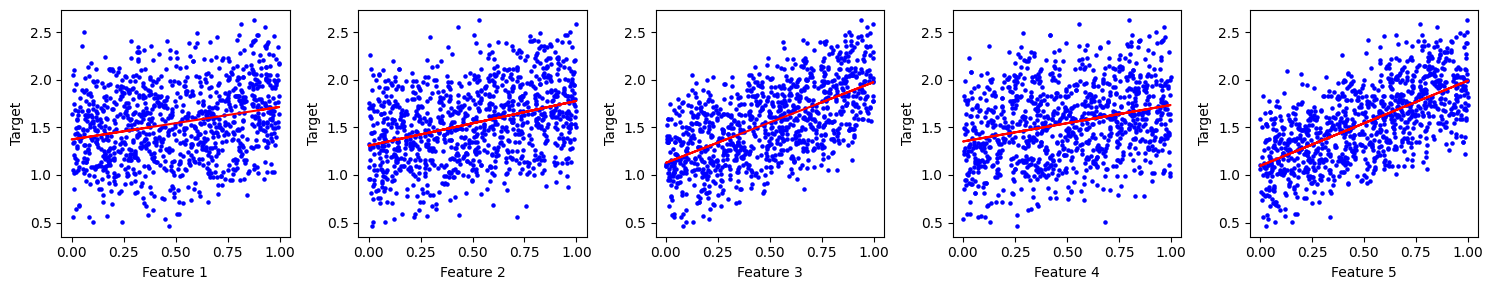

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate random features (X) and target (y)
num_samples = 1000
num_features = 5

X = np.random.rand(num_samples, num_features)
true_coefficients = np.random.rand(num_features)
true_intercept = np.random.rand()
y = np.dot(X, true_coefficients) + true_intercept

# Plotting the data and best fit lines
fig, axs = plt.subplots(1, num_features, figsize=(15, 3))

for feature_index in range(num_features):
    # Plot the data points
    axs[feature_index].scatter(X[:, feature_index], y, s=5, color='b', label='Data')

    # Calculate the best fit line
    coefficients = np.polyfit(X[:, feature_index], y, 1)
    best_fit_line = np.polyval(coefficients, X[:, feature_index])

    # Plot the best fit line
    axs[feature_index].plot(X[:, feature_index], best_fit_line, color='r', label='Best Fit Line')
    axs[feature_index].set_xlabel(f'Feature {feature_index+1}')
    axs[feature_index].set_ylabel('Target')

plt.tight_layout()
plt.show()


### Question 2:
Make a classification dataset of 1000 samples with 2 features, 2 classes and 2 clusters per class.
Plot the data.

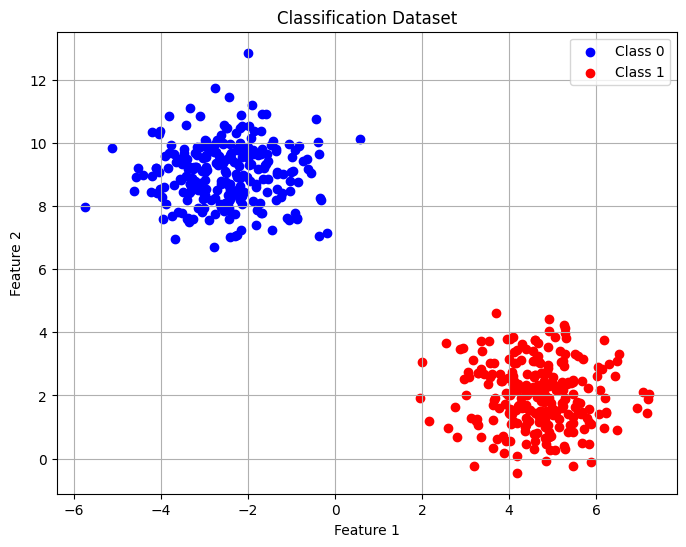

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Set random seed for reproducibility
np.random.seed(42)

# Generate classification dataset
num_samples = 1000
num_features = 2
num_classes = 2
num_clusters_per_class = 2

X, y = make_blobs(
    n_samples=num_samples,
    n_features=num_features,
    centers=num_classes * num_clusters_per_class,
    cluster_std=1.0,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=42
)

# Plotting the data
plt.figure(figsize=(8, 6))

# Separate data points by class
class_0 = X[y == 0]
class_1 = X[y == 1]

# Plot class 0 points
plt.scatter(class_0[:, 0], class_0[:, 1], c='blue', label='Class 0')

# Plot class 1 points
plt.scatter(class_1[:, 0], class_1[:, 1], c='red', label='Class 1')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Dataset')
plt.legend()
plt.grid(True)
plt.show()


### Question 3:
Make a clustering dataset with 2 features and 4 clusters.

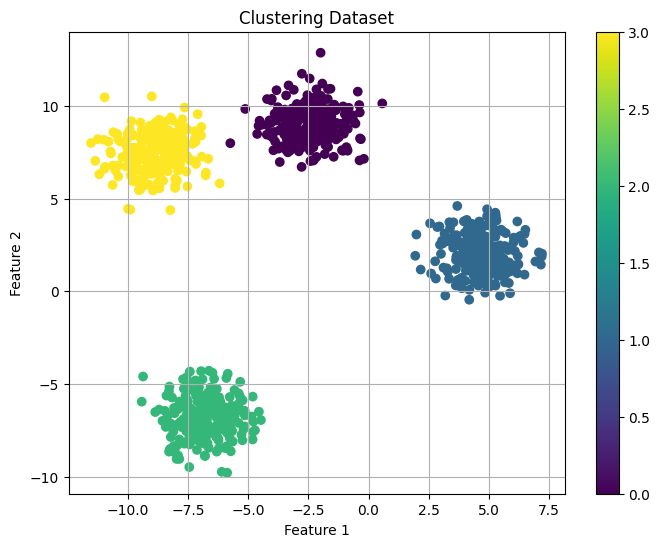

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Set random seed for reproducibility
np.random.seed(42)

# Generate clustering dataset
num_samples = 1000
num_features = 2
num_clusters = 4

X, y = make_blobs(
    n_samples=num_samples,
    n_features=num_features,
    centers=num_clusters,
    cluster_std=1.0,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=42
)

# Plotting the data
plt.figure(figsize=(8, 6))

# Plot all data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clustering Dataset')
plt.colorbar()
plt.grid(True)
plt.show()


## Question 4
Go to the website https://www.worldometers.info/coronavirus/ and scrape the table containing covid-19 infection and deaths data using requests and BeautifulSoup.  Convert the table to a Pandas dataframe with the following columns : Country, Continent, Population, TotalCases, NewCases, TotalDeaths, NewDeaths,TotalRecovered, NewRecovered,  ActiveCases.

*(<b>Optional Challenge :</b> Change the data type of the Columns (Population ... till ActiveCases) to integer. For that you need to remove the commas and plus signs. You may need to use df.apply() and pd.to_numeric() . Take care of the values which are empty strings.)

In [ ]:
import requests as req
url = ' https://www.worldometers.info/coronavirus/'
page= req.get(url)
from bs4 import BeautifulSoup
soup = BeautifulSoup(page.text, 'lxml')
table = soup.find('table', id='main_table_countries_today')

headers = []
first_row=table.find('tr');

for i in first_row.find_all('th'):
 title = i.text
 headers.append(title)

headers

import pandas as pd
mydata = pd.DataFrame(columns = headers)
for j in table1.find_all('tr', )[2:]:
 row_data = j.find_all('td')
 row = [i.text for i in row_data]
 length = len(mydata)
 mydata.loc[length] = row

 columns=['Country,Other','Continent','Population','TotalCases','NewCases','TotalDeaths','NewDeaths','TotalRecovered','NewRecovered','ActiveCases']
mydata=mydata[columns]
mydata.head()
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=1000, n_features=2, n_redundant=0,n_clusters_per_class=1, weights=[0.95], flip_y=0)
import numpy as np
print(np.unique(y,return_counts=True))

import matplotlib.pyplot as plt
plt.scatter(X[:, 0],X[:,1], c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
from imblearn.over_sampling import SMOTE
over = SMOTE(sampling_strategy=0.2638)
X, y = over.fit_resample(X, y)
print(np.unique(y,return_counts=True))
plt.scatter(X[:, 0],X[:,1], c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Question 5

Generate an imbalanced classification dataset using sklearn of 1000 samples with 2 features, 2 classes and 1 cluster per class. Plot the data. One of the class should contain only 5% of the total samples. Confirm this either using numpy or Counter. Plot the data.

Now oversample the minority class to 5 times its initial size using SMOTE. Verify the number. Plot the data.

Now undersample the majority class to 3 times the size of minority class using RandomUnderSampler. Verify the number. Plot the data.

Reference : Last markdown cell of the examples.

(array([0, 1]), array([950,  50], dtype=int64))


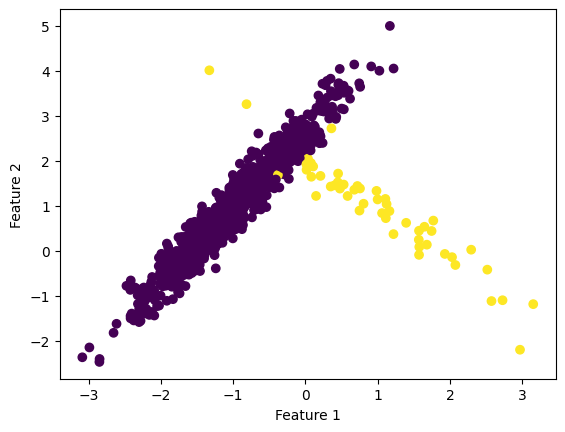

(array([0, 1]), array([950, 250], dtype=int64))


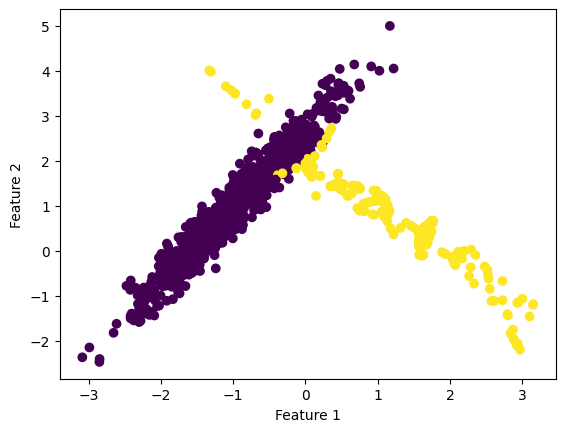

In [9]:
 from sklearn.datasets import make_classification
X,y = make_classification(n_samples=1000, n_features=2, n_redundant=0,n_clusters_per_class=1, weights=[0.95], flip_y=0)
import numpy as np
print(np.unique(y,return_counts=True))

import matplotlib.pyplot as plt
plt.scatter(X[:, 0],X[:,1], c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
from imblearn.over_sampling import SMOTE
over = SMOTE(sampling_strategy=0.2638)
X, y = over.fit_resample(X, y)
print(np.unique(y,return_counts=True))
plt.scatter(X[:, 0],X[:,1], c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

##Question 6

Write a Python code to perform data preprocessing on a dataset using the scikit-learn library. Follow the instructions below:

 * Load the dataset using the scikit-learn `load_iris` function.
 * Assign the feature data to a variable named `X` and the target data to a variable named `y`.
 * Create a pandas DataFrame called `df` using `X` as the data and the feature names obtained from the dataset.
 * Display the first 5 rows of the DataFrame `df`.
 *  Check if there are any missing values in the DataFrame and handle them accordingly.
 * Split the data into training and testing sets using the `train_test_split` function from scikit-learn. Assign 70% of the data to the training set and the remaining 30% to the testing set.
 * Print the dimensions of the training set and testing set respectively.
 *  Standardize the feature data in the training set using the `StandardScaler` from scikit-learn.
 *  Apply the same scaling transformation on the testing set.
 * Print the first 5 rows of the standardized training set.

In [5]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
iris = load_iris()

# Assign the feature data to X and the target data to y
X = iris.data
y = iris.target

# Create a pandas DataFrame
df = pd.DataFrame(X, columns=iris.feature_names)

# Display the first 5 rows of the DataFrame
print(df.head())

# Check for missing values and handle them if necessary
print("Missing values:", df.isnull().sum())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the dimensions of the training and testing sets
print("Training set dimensions:", X_train.shape)
print("Testing set dimensions:", X_test.shape)

# Standardize the feature data in the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same scaling transformation on the testing set
X_test_scaled = scaler.transform(X_test)

# Print the first 5 rows of the standardized training set
df_train_scaled = pd.DataFrame(X_train_scaled, columns=iris.feature_names)
print(df_train_scaled.head())


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
Missing values: sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64
Training set dimensions: (105, 4)
Testing set dimensions: (45, 4)
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0          -0.413416         -1.462003          -0.099511         -0.323398
1           0.551222         -0.502563           0.717703          0.353032
2           0.671802          0.217016           0.951192          0.758890
3           0.912961         -0.022844           0.30